In [1]:
import cv2
import sys
import shutil
import random
import os
import csv
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
from PIL import Image
import pandas as pd
import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop


In [2]:
#create necessary directory if not exists
def create_necessary_folder():
    #make dir for plottings
    if not os.path.exists('plottings'): os.mkdir(f'{os.getcwd()}\\plottings')
    #subfolders for every architecture
    if not  os.path.exists('plottings\\vgg16'): os.mkdir(f'{os.getcwd()}\\plottings\\vgg16')
    if not  os.path.exists('plottings\\vgg19'): os.mkdir(f'{os.getcwd()}\\plottings\\vgg19')
    if not  os.path.exists('plottings\\effnet'): os.mkdir(f'{os.getcwd()}\\plottings\\effnet')
    #make dir for models
    if not os.path.exists('models'): os.mkdir(f'{os.getcwd()}\\models')
    #subfolders for every architecture
    if not  os.path.exists('models\\vgg16'): os.mkdir(f'{os.getcwd()}\\models\\vgg16')
    if not  os.path.exists('models\\vgg19'): os.mkdir(f'{os.getcwd()}\\models\\vgg19')
    if not  os.path.exists('models\\effnet'): os.mkdir(f'{os.getcwd()}\\models\\effnet')

    
create_necessary_folder()


In [3]:
def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch / step_size))
    return LearningRateScheduler(schedule)


def import_dataset(path):
    im = Image.open(path).convert('RGB')
    return im


In [4]:
X, Y = [], []

dataset = pd.read_csv('ground-truth.csv')
EPOCHS = 15
LEARNING_RATE = 1e-3

for index, row in dataset.iterrows():
    X.append(array(import_dataset(row[0]).resize((100, 100))).flatten() / 255.0)
    Y.append(row[1])

X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 100, 100, 3)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.20, random_state=5)

#Load VGG, constrain only for the learning part of the network
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

#Freeze the trainable layers
for layer in vgg_conv.layers[:-5]:
    layer.trainable = False

# Check the trainability for every layer
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

#main architecture
model = Sequential([
    vgg_conv,
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.50),
    Dense(2, activation='softmax')
])
model.summary()

#hyperparameter settings
epochs = EPOCHS
batch_size = 16
optimizer = optimizers.RMSprop(lr=LEARNING_RATE, epsilon=None)
model.compile(optimizer=optimizer,
              loss="mean_squared_error",
              metrics=["accuracy"])

lr_sched = step_decay_schedule(initial_lr=1e-4, decay_factor=0.75, step_size=2)


<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001EAD6F4B288> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001EAD69339C8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001EAD68B5E08> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001EAD6970BC8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001EAD69F50C8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001EAD69F6F48> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001EAD69FFE08> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001EAB85F7408> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001EAB8600C08> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001EAB8600F48> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001EAB8608BC8> False
<tensorflow.python.

In [5]:
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, Y_val), verbose=2,callbacks=[lr_sched])


Train on 1599 samples, validate on 400 samples
Epoch 1/15
1599/1599 - 19s - loss: 0.1503 - accuracy: 0.8005 - val_loss: 0.0526 - val_accuracy: 0.9325
Epoch 2/15
1599/1599 - 15s - loss: 0.0451 - accuracy: 0.9500 - val_loss: 0.0224 - val_accuracy: 0.9775
Epoch 3/15
1599/1599 - 15s - loss: 0.0358 - accuracy: 0.9612 - val_loss: 0.0480 - val_accuracy: 0.9500
Epoch 4/15
1599/1599 - 15s - loss: 0.0334 - accuracy: 0.9644 - val_loss: 0.0568 - val_accuracy: 0.9250
Epoch 5/15
1599/1599 - 15s - loss: 0.0281 - accuracy: 0.9719 - val_loss: 0.0189 - val_accuracy: 0.9800
Epoch 6/15
1599/1599 - 15s - loss: 0.0271 - accuracy: 0.9731 - val_loss: 0.0230 - val_accuracy: 0.9775
Epoch 7/15
1599/1599 - 15s - loss: 0.0273 - accuracy: 0.9725 - val_loss: 0.0197 - val_accuracy: 0.9800
Epoch 8/15
1599/1599 - 15s - loss: 0.0280 - accuracy: 0.9712 - val_loss: 0.0200 - val_accuracy: 0.9800
Epoch 9/15
1599/1599 - 15s - loss: 0.0262 - accuracy: 0.9731 - val_loss: 0.0202 - val_accuracy: 0.9800
Epoch 10/15
1599/1599 - 15

In [6]:
import random
#assign random code to make unique ID
r = random.randint(1, 1000)
print(f'[INFO] Your unique ID is {r}, refer to this ID to check the latest data!')
ID = f'{LEARNING_RATE}n{EPOCHS}_{r}'

[INFO] Your unique ID is 70, refer to this ID to check the latest data!


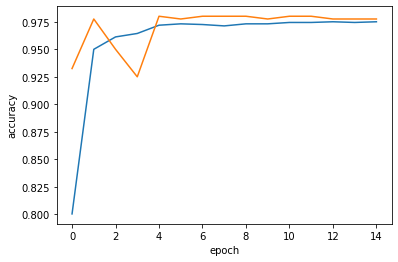

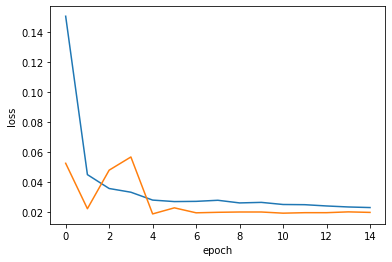

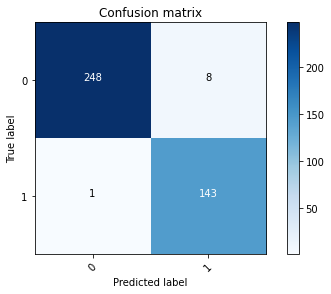

In [7]:
#plotting
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.savefig(f'plottings\\vgg16\\acc_{ID}.png')
plt.show()

#plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.savefig(f'plottings\\vgg16\\loss_{ID}.png')
plt.show()

Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val, axis=1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(2))
plt.savefig(f'plottings\\vgg16\\cnfmtx_{ID}.png')
plt.show()

In [8]:
#save model
model_name = f'models\\vgg16\\{ID}.h5'
model.save(model_name)

In [9]:
with open('currently-used-vgg16.txt','w+') as f:
    f.write(model_name)

In [10]:
train_acc, val_acc = np.mean(history.history['accuracy']), np.mean(history.history['val_accuracy'])
print(train_acc, val_acc)

0.9589326 0.97016674


## Testing

In [11]:
from tensorflow.keras.models import load_model
import tensorflow as tf
#test_set = glob.glob('MICC-F220\\*')
test_set = glob.glob('test_set\\*')
classes = []
for img in test_set:
    #data will have the label `tamp` if the data is tampered
    if 'tamp' in img and img[len(img)-4:len(img)] == '.jpg':
        classes.append('forged')
    elif 'tamp' not in img and img[len(img)-4:len(img)] == '.jpg':
        classes.append('unforged')

#for i in range(len(test_set)): print(test_set[i], classes[i])
#def predict():
#load model
model = load_model(model_name)
predictions = []
#test image iteration
for i in tf.range(len(test_set)): #use tf.range for faster execution (operation is done in tf.Tensor)
    image = Image.open(test_set[i]).convert('RGB')
    image = array(image.resize((100,100))).flatten() / 255.0
    image = image.reshape(-1,100,100,3)
    pred = model.predict(image)[0]
    #take the index of the predicted class
    index = np.argmax(pred)
    verdict = "forged" if index == 1 else "unforged"
    predictions.append(verdict)

In [15]:
correct = 0
for i in range(len(classes)):
    if classes[i] == predictions[i]:
        correct += 1
    else: continue
acc = correct / len(classes)
print(f'Test accuracy: {round(acc*100,3)}%')

Test accuracy: 83.333%


In [13]:
with open(f'plottings\\vgg16\\testacc_{ID}.txt','w+') as f:
    f.write(f'train_acc: {train_acc}\nval_acc: {val_acc}\n')
    f.write(f'test_acc: {acc}')

C:\Users\jdk\.conda\envs\project\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  if __name__ == '__main__':


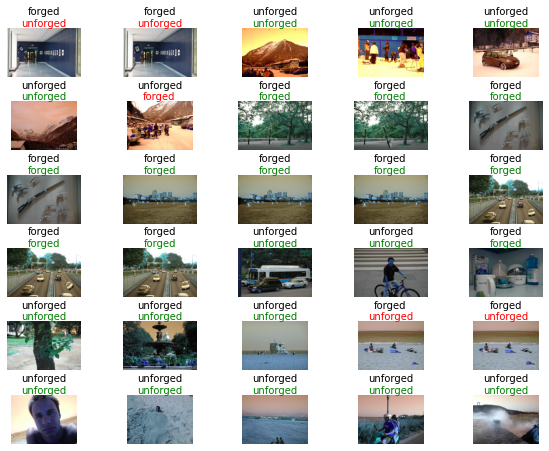

In [14]:
#for i in range(len(classes)): print(classes[i], predictions[i])
correct = 0
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for i in range(len(classes)):
    im = cv2.imread(test_set[i])
    #im.resize((30,30))
    #print(im.shape)
    plt.subplot(len(classes)/5+1,5,i+1)
    plt.imshow(im)
    color = 'green' if classes[i] == predictions[i] else 'red'
    if color == 'green': correct += 1
    #plt.title(f'{classes[i]}\n{predictions[i]}', color=color)
    plt.text(im.shape[1]/2,0,f'{classes[i]}\n', ha="center", va="bottom", size="medium")
    plt.text(im.shape[1]/2,0,f'\n{predictions[i]}', ha="center", va="bottom", size="medium",color=color)
    plt.axis('off')

plt.savefig(f'plottings\\vgg19\\test_{ID}.png')
plt.show()
